# imports

In [12]:
import os, sys, time
import tifffile as tif
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import csv

from scipy import ndimage
import scipy.stats as st
import seaborn as sns

# User inputs

In [13]:
# set a base directory where your folders live
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"
mask  = tif.imread(os.path.join(src,'tiffs/matlas_mask.tif'))
reg_vol_name = "matlas"

In [40]:
# make a list of all the volumes
#manually change the # in line 11
grp1 = ["f110","t107","f002","f003"]
grp2 = ["a235","e106","c514","k320"]
#grp1=['tom1','tom2','tom3','tom4','tom5','tom6','tom7','tom8']
#grp2=['f110','t107','f002','f003','a235','e106','c514','k320']
grp1n=len(grp1)
grp2n=len(grp2)
vol_list = grp1+grp2

# Define functions

In [41]:
def get_all_values_above_zero(volumes_in):
    volumes_out = np.ravel([volumes_in])
    volumes_out = volumes_out[volumes_out>0]

    return volumes_out

In [42]:
def make_magnitude_array(inputarray):
    outputarray = np.sqrt(np.square(inputarray[:,:,:,0])+np.square(inputarray[:,:,:,1])+np.square(inputarray[:,:,:,2]))
    return outputarray

# net jacobians

In [43]:
grp1_adjjac_vols = []
grp2_adjjac_vols = []
grp1_med = []
grp2_med = []
grp1_jac_vols = []
grp2_jac_vols = []
for i in np.arange(len(vol_list)):
    fld = os.path.join(src,"output_dirs/{}_in_{}".format(vol_list[i],reg_vol_name))
    jac = tif.imread(os.path.join(fld,"spatialJacobian.tif"))
    medjac = np.median(jac)
    print(medjac)
    adjjac = (jac/medjac)*(mask/255)
    #tif.imsave(os.path.join(src,"tiffs/{}_adjjac.tif".format(vol_list[i])),adjjac)
    if vol_list[i] in grp1:
        print("adding {} to grp1".format(vol_list[i]))
        grp1_med.append(medjac)
        grp1_jac_vols.append(jac)
        grp1_adjjac_vols.append(adjjac)
    else:
        print("adding {} to grp2".format(vol_list[i]))
        grp2_med.append(medjac)
        grp2_jac_vols.append(jac)
        grp2_adjjac_vols.append(adjjac)

2.69221
adding f110 to grp1
2.5692337
adding t107 to grp1
2.2396712
adding f002 to grp1
2.1512392
adding f003 to grp1
3.1251633
adding a235 to grp2
3.4251492
adding e106 to grp2
3.5551023
adding c514 to grp2
2.391899
adding k320 to grp2


In [44]:
grp1_jac_vals = get_all_values_above_zero(grp1_jac_vols)
grp2_jac_vals = get_all_values_above_zero(grp2_jac_vols)
grp1_adjjac_vals = get_all_values_above_zero(grp1_adjjac_vols)
grp2_adjjac_vals = get_all_values_above_zero(grp2_adjjac_vols)

Text(0.5, 1.0, 'before adjustment, all jacobian values for all voxels')

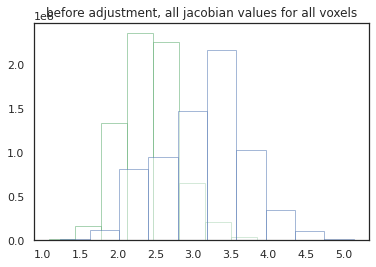

In [45]:
plt.hist(grp1_jac_vals,edgecolor='g',color='w',alpha=0.5)
plt.hist(grp2_jac_vals,edgecolor='b',color='w',alpha=0.5)
plt.title('before adjustment, all jacobian values for all voxels')

Text(0.5, 1.0, 'after adjustment, all jacobian values for all voxels')

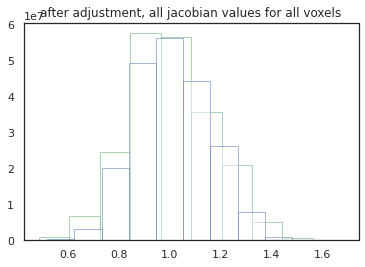

In [46]:
plt.hist(grp1_adjjac_vals,edgecolor='g',color='w',alpha=0.5)
plt.hist(grp2_adjjac_vals,edgecolor='b',color='w',alpha=0.5)
plt.title('after adjustment, all jacobian values for all voxels')

Text(0.5, 1.0, 'median values for each volume')

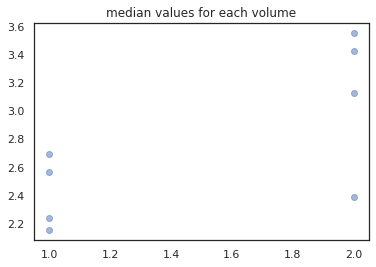

In [47]:
plt.scatter([np.ones(grp1n),2*(np.ones(grp2n))],[grp1_med,grp2_med],alpha=0.5)
plt.title('median values for each volume')

In [48]:
sigma_ann_in_matlas = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/sigma_ann_in_matlas.tif')
sigma_labels = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_in_PRA.csv')
sigma_labels = sigma_labels.drop(columns=['Unnamed: 0'])

In [ ]:
df = sigma_labels.copy()
adjjac_by_region = {}
for idx in sigma_labels.index:
    sigma_ann_in_matlas[sigma_ann_in_matlas==int(sigma_labels.ID[idx])]=int(sigma_labels.praid[idx])

# for each animal, get avg jac PER REGION
for i in np.arange(0,len(vol_list)):
    # get animal name
    animal = vol_list[i]
    print(animal)
    # get adjjac vals
    if animal in grp1:
        adjjac_vol = grp1_adjjac_vols[i]
    else:
        adjjac_vol = grp2_adjjac_vols[i-grp1n]      
    # insert a column for this animal into the df
    df.insert(2,animal,np.nan)
    # segment by region
    for idx in df.index:
        df.at[idx,animal] = np.median(adjjac_vol[sigma_ann_in_matlas==int(df.praid[idx])])
    

f110


/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/emilyjanedennis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


t107
f002
f003
a235


In [ ]:
# plot as a scatter plot for eavh animal, color by group
plt.figure(figsize=(20,7))
a=.2
sz=10
for animal in grp1:
    plt.scatter(df.praid,df[animal],s=sz,c='hotpink',alpha=a)
for animal in grp2:
    plt.scatter(df.praid,df[animal],s=sz,c='orange',alpha=a)
plt.show()

In [ ]:
# get the net (fem - mal or mus - rattus) jac for EACH REGION 

# get median grp1, grp2 brains
grp1_med_matrix = np.median(grp1_adjjac_vols,axis=0)
grp2_med_matrix = np.median(grp2_adjjac_vols,axis=0)

net_brain = np.subtract(grp1_med_matrix,grp2_med_matrix)

for idx in sigma_labels.index:
    sigma_ann_in_matlas[sigma_ann_in_matlas==int(sigma_labels.ID[idx])]=int(sigma_labels.praid[idx])

df.insert(2,'net_brain_jacs',np.nan)
# segment by region
for idx in df.index:
        df.at[idx,'net_brain_jacs'] = np.median(net_brain[sigma_ann_in_matlas==int(df.praid[idx])])
df    

In [ ]:
order_rows = np.argsort(np.asarray(df.net_brain_jacs.copy()))

y=df.net_brain_jacs.copy()[order_rows]
x=df.common_name.copy()[order_rows]

In [ ]:
plt.figure(figsize=(20,14))
plt.bar(x,y,color='lightgray')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(14, 20), dpi=300)
sns.set(font_scale=1,style='white')
sns.barplot(x=y,y=x,orient='horizontal',color='lightgray')

In [ ]:
plt.hist(y)
plt.show()

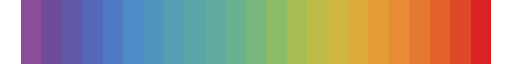

In [166]:
# LATER want to color by praid, using
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)
cell_rainbow

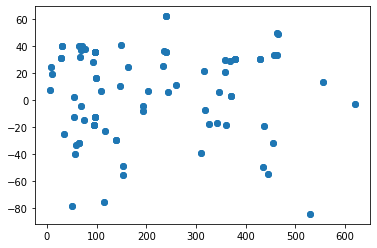

In [123]:
plt.scatter(df.praid,df.net_brain_jacs)

# Geometric displacements

In [17]:
for i in np.arange(len(vol_list)):
    sqrtaffinebrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_{}_affine/deformationField.tif".format(vol_list[i],reg_vol_name))))
    sqrtfullbrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_{}/deformationField.tif".format(vol_list[i],reg_vol_name))))
    netbrain = sqrtfullbrain - sqrtaffinebrain
    if vol_list[i] in grp_1:
        print("adding {} to grp1".format(vol_list[i]))
        grp_1_netdefo.append(netbrain)
    else:
        print("adding {} to grp2 vols".format(vol_list[i]))
        grp_2_netdefo.append(netbrain)

adding f110 to female vols
adding t107 to female vols
adding f002 to female vols
adding f003 to female vols
adding k320 to male_vols
adding k321 to male_vols
adding k323 to male_vols
adding k327 to male_vols


# stopped working here 

In [18]:
i=4
sqrtaffinebrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_PRA_affine/deformationField.tif".format(vol_list[i]))))
sqrtfullbrain = make_magnitude_array(tif.imread(os.path.join(src,"output_dirs/{}_in_PRAf_seed4/deformationField.tif".format(vol_list[i]))))
netbrain = sqrtfullbrain - sqrtaffinebrain
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_affine_mag.tif",sqrtaffinebrain)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_full_mag.tif",sqrtfullbrain)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/k320_net_mag.tif",netbrain)

In [19]:
netdefo_PRA = np.median(mascsd,0) - np.median(femsd,0)
tif.imsave("/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netdefo_PRA.tif",netdefo_PRA)

In [207]:
mtest = np.median(mascs,0)
netjac_PRAf = test-mtest
tif.imsave('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netjac_PRAf.tif',netjac_PRAf)

In [8]:
avgjac_f_in_f = tif.imread(os.path.join(src,'tiffs/avgjac_f_PRAf.tif'))
avgjac_f_in_m = tif.imread(os.path.join(src,'tiffs/avgjac_f_PRAm.tif'))
avgjac_m_in_f = tif.imread(os.path.join(src,'tiffs/avgjac_m_PRAf.tif'))
avgjac_m_in_m = tif.imread(os.path.join(src,'tiffs/avgjac_m_PRAm.tif'))

In [23]:
# 2021-03-05 stopped here -- waiting on elastix/transformix of labeled volume to m_matlas_alt space
netjac_PRAf = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/netjac_PRAf.tif')

In [20]:
whs_m = tif.imread(os.path.join(src,'tiffs/WHS_in_PRAm_seed4.tif'))
whs_f = tif.imread(os.path.join(src,'tiffs/WHS_in_PRAf_seed4.tif'))
whs_labs = pd.read_csv(os.path.join(src,'labels/whs_with_parents.csv'))
sigma_m = tif.imread(os.path.join(src,'tiffs/SIGMA_in_PRAm_seed4.tif'))
sigma_f = tif.imread(os.path.join(src,'tiffs/SIGMA_in_PRAf_seed4.tif'))
sigma_labs = pd.read_csv(os.path.join(src,'labels/sigma_with_parents.csv'))

In [24]:
for i in np.unique(sigma_labs['id']):
    if np.isreal(i):
        if i%2 ==0:
            print(i)
            meanval=np.mean(netjac_PRAf[(sigma_f==i) | (sigma_f==i-1)])
            sigma_f = np.where(sigma_f == i, meanval,sigma_f)
            sigma_f = np.where(sigma_f == i-1, meanval,sigma_f)

0.0
12.0
22.0
32.0
42.0
52.0
62.0
72.0
82.0
92.0
102.0
112.0
122.0
132.0
142.0
152.0
162.0
172.0
182.0
192.0
202.0
212.0
222.0
232.0
242.0
252.0


KeyboardInterrupt: 

In [22]:
#tif.imsave('/home/emilyjanedennis/scratch/sigma_netdefo.tif',sigma_f)

In [38]:
tif.imsave('/home/emilyjanedennis/brody/ejdennis/sigma_f.tif',sigma_f)

In [37]:
tif.imsave('/home/emilyjanedennis/Desktop/sigma_f.tif',sigma_f)

In [243]:
sigma_labs.to_csv('/home/emilyjanedennis/Desktop/sigma_labs_with_jacs_PRAs.csv')

In [246]:
med_f = np.median(sigma_labs.jacval.dropna())

In [247]:
ste_f = np.std(sigma_labs.jacval.dropna())/np.sqrt(len(sigma_labs.jacval.dropna()))

(618, 1150, 355)

In [256]:
dfgrpd = sigma_labs.groupby(['common_name','pra_id','parent']).mean()
dfgrpd = dfgrpd.reset_index()

dfsub = dfgrpd[abs(dfgrpd.jacval) > (12*ste_f)]
#dfsub=dfsub[['common_name','pra_id','jacval_net_in_f']].dropna()
len(dfsub)

67

<AxesSubplot:xlabel='jacval', ylabel='common_name'>

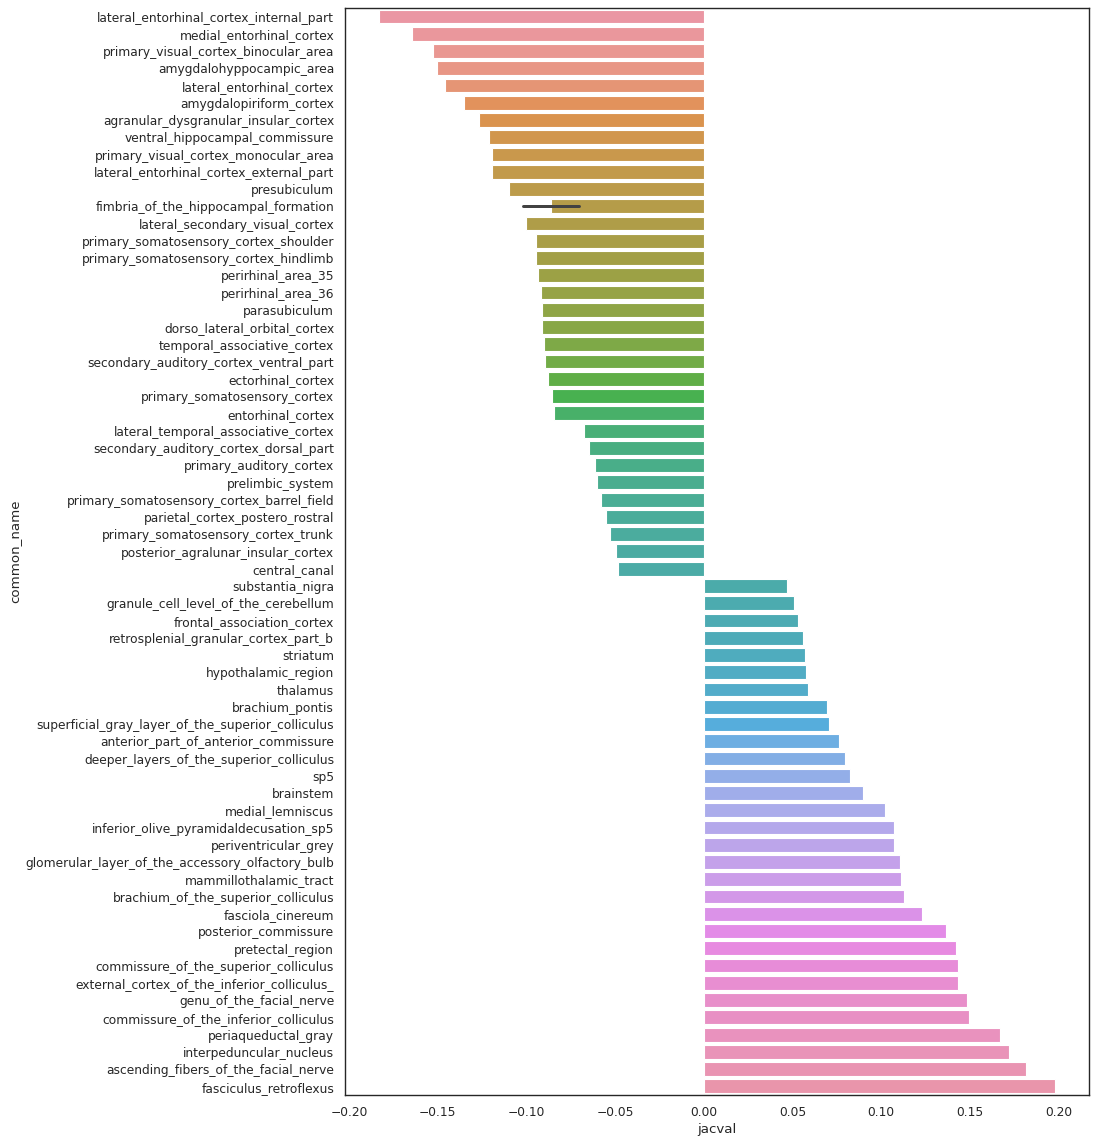

In [259]:
plt.figure(figsize=(12, 18), dpi=80)
sns.set(font_scale=1,style='white')
sns.barplot(data=dfsub.sort_values(['jacval']),x='jacval',y='common_name',orient='horizontal')

In [127]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [139]:
a=jacvals.dropna()
st.t.interval(0.995, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(-0.025072878104552616, 0.04288187544089411)

In [137]:
# also do with log transformed jacs from ea vol

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: alpha must be between 0 and 1 inclusive

In [103]:
avgjac - 2*std

-0.24338995219192586

/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/lightsheet/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


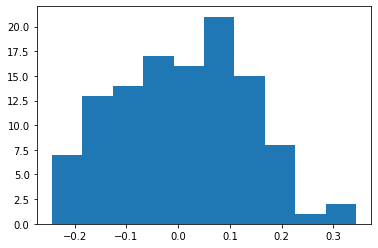

In [89]:
plt.hist(jacvals)
plt.show()

In [2]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/"
vol_list= ["tom1","tom2","tom3","tom4","e106","a235","k320","c514_3"]

6

In [230]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"

fann = os.path.join(src,"tiffs/fPRA_to_PRA_net_jacobian.tif")
#fann = os.path.join(src,"output_dirs/SIGMA_in_fPRA/result.tif")
#fann_affine = os.path.join(src, "output_dirs/SIGMA_fPRA_in_PRA_affine/result.tif")
mann = os.path.join(src, "output_dirs/SIGMA_ann_in_PRA_25/result.tif")

#fann = os.path.join(src, "tiffs/WHS_ann_in_fPRA.tif")
#mann = os.path.join(src, "output_dirs/WHS_ann_in_PRA25/WHS_anns_in_PRA25.tif")

#annotationsfilename=os.path.join(src,"labels/labels_v3.csv")

annotationsfilename = os.path.join(src,"labels/SIGMA_good_labels.csv")
output= "/home/emilyjanedennis/Desktop/mf_SIGMA.tiff"
percentcsv="/home/emilyjanedennis/Desktop/mf_percent_SIGMA.csv"

## get percent of each brain for a given 'value' or label

In [231]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1,2],header=0)
print("read annotations")

read annotations


In [232]:
df=anns.dropna()
df


atlas    ID                                 label
0     Tohoku    11  Agranular Dysgranular Insular Cortex
1     Tohoku    12  Agranular Dysgranular Insular Cortex
2     Tohoku    21              Agranular Insular Cortex
3     Tohoku    22              Agranular Insular Cortex
4     Tohoku    31              Amygdalohyppocampic Area
..       ...   ...                                   ...
177  Waxholm  1132                             Thalamus 
178  Waxholm  1141                       Brachium Pontis
179  Waxholm  1142                       Brachium Pontis
180  Waxholm  1161                  Periventricular Grey
181  Waxholm  1162                  Periventricular Grey

[182 rows x 3 columns]

In [233]:
df.insert(3,'fvox',0)
df.insert(4,'fvox_affine',0)
df.insert(5,'mvox',0)


In [234]:
ftiff = tif.imread(fann)
#faffinetiff = tif.imread(fann_affine)
mtiff = tif.imread(mann)
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')

In [235]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])

<ipython-input-235-01c5cdf64e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])


In [236]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
fsigmatiff = msigmatiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        fsigmatiff[fsigmatiff==i]=0

0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [237]:
np.max(fsigmatiff)

181

In [238]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() > 0.1:
        print(np.shape(fsigmatiff[fsigmatiff==i]))
        fsigmatiff[fsigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
(54968,)


<ipython-input-238-ae2ce6616ac2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() > 0.1:


1    221
Name: fvox, dtype: int16
(55343,)
2    37
Name: fvox, dtype: int16
(372549,)
3    234
Name: fvox, dtype: int16
(383733,)
4    116
Name: fvox, dtype: int16
(35191,)
5    78
Name: fvox, dtype: int16
(32045,)
6    149
Name: fvox, dtype: int16
(273770,)
7    170
Name: fvox, dtype: int16
(252711,)
8    196
Name: fvox, dtype: int16
(1323564,)
9    210
Name: fvox, dtype: int16
(1365468,)
10    271
Name: fvox, dtype: int16
(44955,)
11    289
Name: fvox, dtype: int16
(45487,)
12    174
Name: fvox, dtype: int16
(503913,)
13    165
Name: fvox, dtype: int16
(484677,)
14    178
Name: fvox, dtype: int16
(80373,)
15    170
Name: fvox, dtype: int16
(77194,)
16    234
Name: fvox, dtype: int16
(463119,)
17    243
Name: fvox, dtype: int16
(437168,)
18    236
Name: fvox, dtype: int16
(711879,)
19    244
Name: fvox, dtype: int16
(676271,)
20    117
Name: fvox, dtype: int16
(84468,)
21    378
Name: fvox, dtype: int16
(80631,)
22    74
Name: fvox, dtype: int16
(206293,)
23    178
Name: fvox, dtype: 

In [239]:
np.max(fsigmatiff)

405

In [240]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
msigmatiff= SIGMAtiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        msigmatiff[msigmatiff==i]=0


0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [241]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() < 0:
        print(np.shape(msigmatiff[msigmatiff==i]))
        msigmatiff[msigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
1    221
Name: fvox, dtype: int16
2    37
Name: fvox, dtype: int16
3    234
Name: fvox, dtype: int16
4    116
Name: fvox, dtype: int16
5    78
Name: fvox, dtype: int16
6    149
Name: fvox, dtype: int16
7    170
Name: fvox, dtype: int16
8    196
Name: fvox, dtype: int16
9    210
Name: fvox, dtype: int16
10    271
Name: fvox, dtype: int16
11    289
Name: fvox, dtype: int16
12    174
Name: fvox, dtype: int16
13    165
Name: fvox, dtype: int16
14    178
Name: fvox, dtype: int16
15    170
Name: fvox, dtype: int16
16    234
Name: fvox, dtype: int16
17    243
Name: fvox, dtype: int16
18    236
Name: fvox, dtype: int16
19    244
Name: fvox, dtype: int16
20    117
Name: fvox, dtype: int16
21    378
Name: fvox, dtype: int16
22    74
Name: fvox, dtype: int16
23    178
Name: fvox, dtype: int16
24    36
Name: fvox, dtype: int16
25    1
Name: fvox, dtype: int16
26    233
Name: fvox, dtype: int16
27    235
Name: fvox, dtype: int16
28    241
Name: fvox, dtype: int16
29 

<ipython-input-241-21cdfcfacca2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() < 0:


50    132
Name: fvox, dtype: int16
51    70
Name: fvox, dtype: int16
52    200
Name: fvox, dtype: int16
53    195
Name: fvox, dtype: int16
54    185
Name: fvox, dtype: int16
55    116
Name: fvox, dtype: int16
56    188
Name: fvox, dtype: int16
57    131
Name: fvox, dtype: int16
58    100
Name: fvox, dtype: int16
59    379
Name: fvox, dtype: int16
60    137
Name: fvox, dtype: int16
61    55
Name: fvox, dtype: int16
62    110
Name: fvox, dtype: int16
63    55
Name: fvox, dtype: int16
64    13
Name: fvox, dtype: int16
65   -52
Name: fvox, dtype: int16
(0,)
66    89
Name: fvox, dtype: int16
67    16
Name: fvox, dtype: int16
68    252
Name: fvox, dtype: int16
69    257
Name: fvox, dtype: int16
70    120
Name: fvox, dtype: int16
71    61
Name: fvox, dtype: int16
72    98
Name: fvox, dtype: int16
73    10
Name: fvox, dtype: int16
74    103
Name: fvox, dtype: int16
75    34
Name: fvox, dtype: int16
76    181
Name: fvox, dtype: int16
77    164
Name: fvox, dtype: int16
78    113
Name: fvox, dtyp

In [242]:
tif.imsave('/home/emilyjanedennis/Desktop/msigma.tif',msigmatiff)
tif.imsave('/home/emilyjanedennis/Desktop/fsigma.tif',fsigmatiff)

array([], dtype=int16)

In [146]:
print(np.max(SIGMAtiff))
print(np.min(SIGMAtiff))

0
0


In [8]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
    df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


<ipython-input-8-5162a856bfbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])


In [9]:
df = df[df.fvox > 0]


In [10]:
df

Empty DataFrame
Columns: [atlas, ID, label, fvox, fvox_affine, mvox]
Index: []

In [10]:
df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
df['fa_m_over_fam']= (df['fpct_affine']-df['mpct'])/(df['fpct_affine']+df['mpct'])
df['fa_vox_vs_m'] = (df.fvox_affine - df.mvox)/(df.mvox)
df

<ipython-input-10-cd99e5788101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
<ipython-input-10-cd99e5788101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
<ipython-input-10-cd99e5788101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

atlas    ID                                     label     fvox  \
1    Waxholm   171                           Globus Pallidus     2572   
2    Waxholm   731                                  Striatum  1466457   
3    Waxholm   221      Granule Cell Level of the Cerebellum  1018451   
4    Waxholm   341         Molecular Layer of the Cerebellum  3429328   
5     Tohoku    31                  Amygdalohyppocampic Area    26485   
..       ...   ...                                       ...      ...   
229  Waxholm   882     Commissure of the Superior Colliculus     2630   
230  Waxholm   902  Deeper Layers of the Superior Colliculus   433198   
231  Waxholm  1082                                       SP5    24785   
232  Waxholm   792      Anterior Commissure Intrabulbar part    37530   
233  Waxholm  1122                           Optic Pathways     31295   

     fvox_affine     mvox      fpct  fpct_affine      mpct  fa_m_over_fam  \
1           3265     2844  0.004230     0.004364  0.004000       0.043506   
2        1813067  1664466  2.411643     2.423155  2.340903       0.017265   
3        1259382  1265190  1.674881     1.683158  1.779362      -0.027784   
4        4238434  4095170  5.639657     5.664646  5.759442      -0.008298   
5          32843    35191  0.043556     0.043895  0.049493      -0.059945   
..           ...      ...       ...          ...       ...            ...   
229         3297     2401  0.004325     0.004406  0.003377       0.132293   
230       535986   440010  0.712410     0.716343  0.618829       0.073034   
231        30876    29813  0.040760     0.041266  0.041929      -0.007973   
232        46420    45913  0.061719     0.062040  0.064572      -0.019997   
233        38663    37760  0.051466     0.051673  0.053106      -0.013674   

     fa_vox_vs_m  
1       0.148031  
2       0.089278  
3      -0.004591  
4       0.034984  
5      -0.066722  
..           ...  
229     0.373178  
230     0.218122  
231     0.035656  
232     0.011043  
233     0.023914  

[232 rows x 11 columns]

In [11]:
df.to_csv('/home/emilyjanedennis/Desktop/fa_vals.csv')

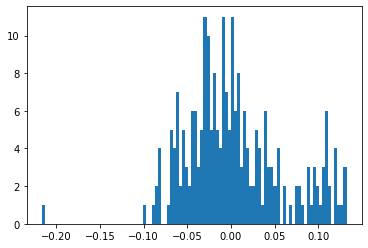

In [13]:
plt.hist(df.fa_m_over_fam,bins=100)
plt.show()

In [70]:
mp = 0
sp = np.nanstd(df.fg)

In [71]:
highmp = mp+sp
highmp
highermp = mp+(2*sp)

In [72]:
lowmp = mp-(0.5*sp)
lowmp
lowermp=mp-(2*sp)

In [17]:
df=pd.read_csv(percentcsv)

In [69]:
mp

-0.0045578046095393135

1162

In [148]:
# want to take IDs and set all to 0 except fg > highmp == 800, fg > higher mp == 1000
# fg < lowmp == 600, fg < lowermp == 500
# then save the tiff
sex_relative = tif.imread(mann)
np.max(sex_relative)

for i in df['ID']:
    if df[df['ID']==i]['fg'].item() >.09:
        sex_relative[sex_relative==i]=1000
    else:
        sex_relative[sex_relative==i]=0

In [149]:
tif.imsave('/home/emilyjanedennis/Desktop/hi_sigma.tif',sex_relative)

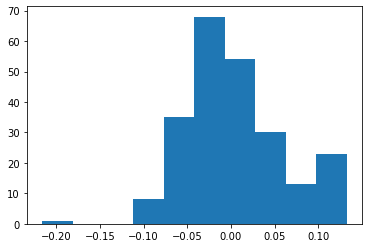

In [104]:
plt.hist(df['fg'])
plt.show()

In [142]:
np.sum(df['fg']<-.06)

24

In [143]:
np.sum(df['fg']>.09)

27

-0.11149420498351735